# Carregando dados e gerenciar checkpoints
- O objetivo deste notebook é aprendermos as seguintes features do PyTorch:
    1. Criar datasets customizados que nos permita carregar dados do disco
    2. Criar e gerênciar checkpoints do treinamento

In [2]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from PIL import Image

## Carregando novos datasets
- Até o momento nos carregamos dados usando o `torchvision.datasets`, que basicamente nos retorna uma instância personalizada do `torch.utils.data.Dataset`
- Para carregarmos os nossos próprios datasets precisamos criar uma instância desse mesmo objeto
- E na sequência, passar esse dataset para um `torch.utils.data.Dataloader`
- Então vamos começar com o dataset
    - Para criar um dataset customizado, basta estender a classe `torch.utils.data.Dataset`
    - E a partir dai, você decise a maneira que deseja carregar os dados seguindo a padronização do framework

In [3]:
class MyDataset (torch.utils.data.Dataset):
    """
    Esse dataset recebe uma lista de path de imagens, uma lista de labels correspondentes e (opcional) transformações pata aplicar nas imagens
    quando elas forem carregadas
    """

    def __init__(self, imgs_path, labels, my_transform=None):
        """
        imgs_path: list ou tuple
            Uma lista ou tupla com os paths para todas as imagens
        labels: lista ou tuple
            Uma lista ou tupla com o label de todas as imagens. Obviamente, precisa dar match com o os paths
        my_transform: None ou torchvision.transforms
            Uma sequência de transformadores para aplicar nos dados. Se for None, ele apenas transforma em tensor
        """

        super().__init__()
        self.imgs_path = imgs_path
        self.labels = labels
        
        # se my_transform for None, precisamos garantir que a imagem PIL seja transformada em Tensor para nao 
        # obtermos um erro quando usarmos o dataloader (ver aulas passadas)        
        if my_transform is not None:
            self.transform = my_transform
        else:
            self.transform = transforms.ToTensor()


    def __len__(self):     
        """
        Sobrecarga do método len para obtermos o tamanho do dataset. Não é obrigatório implementar
        """
        return len(self.imgs_path)


    def __getitem__(self, item):        
        """
        Esse método obtém uma imagem e um label cada vez que iteramos no Dataset. Ele também aplica a transformação
        na imagem. É obrigatório sua implementação
        
        item: int 
            Um indice no intervalo [0, ..., len(img_paths)-1]
        
        return: tuple 
             Uma tupla com a imagem, label e ID da imagem correspondentes ao item
        """

        # Aqui usamos PIL para carregar as imagens
        image = Image.open(self.imgs_path[item]).convert("RGB")

        # Aplicando as transformações
        image = self.transform(image)

        # Obtendo o ID da imagem
        img_id = self.imgs_path[item].split('/')[-1].split('.')[0]

        if self.labels is None:
            labels = []
        else:
            labels = self.labels[item]

        return image, labels, img_id

### Preparando dados para criarmos um dataset
- A nossa classe espera receber uma lista de imagens e labels. Portanto, precisamos preparar isso primeiro
- Como exemplo, vamos carregar um dataset chamado felinos
    - Ele contém imagens de 4 felines: leão, leopardo, tigre e gato
    - A ideia é criar um classificador para identificar o felino
    - Mas primeiro, precisamos carregar os dados

In [4]:
from glob import glob
import os
import matplotlib.pyplot as plt

In [5]:
train_data_path = "./felinos/train"
test_data_path = "./felinos/test"

In [6]:
labels_name = glob(os.path.join(train_data_path, "*"))
labels_name = [l.split(os.path.sep)[-1] for l in labels_name]
labels_name

['tiger', 'cat', 'leopard', 'lion']

In [7]:
def get_paths_and_labels(path, lab_names):
    imgs_path, labels = list(), list()
    lab_cnt = 0
    for lab in lab_names:    
        paths_aux = glob(os.path.join(path, lab, "*.jpg"))
        
        # Atualizando os labels e imgs_paths
        labels += [lab_cnt] * len(paths_aux)
        imgs_path += paths_aux
        
        lab_cnt += 1
        
    return imgs_path, labels

- Obtendo paths e labels para cada partição

In [8]:
train_imgs_paths, train_labels = get_paths_and_labels(train_data_path, labels_name)
test_imgs_paths, test_labels = get_paths_and_labels(test_data_path, labels_name)

- Alguns testes de sanidade

In [9]:
len(train_imgs_paths), len(train_labels)

(200, 200)

In [10]:
test_imgs_paths[120], test_labels[120]

('./felinos/test/leopard/378.jpg', 2)

### Instanciando os datasets

In [11]:
train_dataset = MyDataset(train_imgs_paths, train_labels)
test_dataset = MyDataset(test_imgs_paths, test_labels)
train_dataset

Text(0.5, 1.0, '40 | cat')

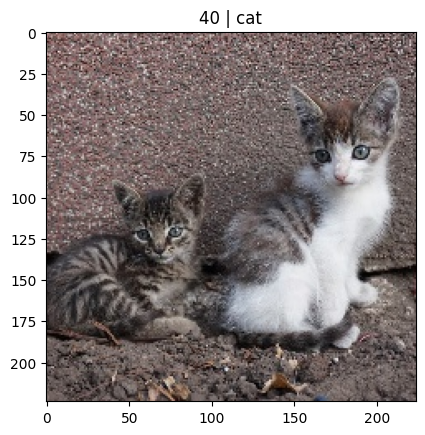

In [12]:
img, label, idimg = train_dataset[80]
plt.imshow(img.permute(1, 2, 0))
plt.title(idimg + " | " + labels_name[label])

In [15]:
img.shape

torch.Size([3, 224, 224])

### Criando um Dataloader
- Agora, podemos criar um [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) como fizemos nas últimas duas aulas

In [14]:
batch_size = 30
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

## Gerenciamento de checkpoints
- Criar checkpoints durante o treinamento é essêncial para nao perdermos todo o trabalho em caso de algum problema
- O Pytorch disponibiliza os métodos `torch.save()` e `torch.load()` para auxiliar nesse gerenciamento

- Todos os pesos de um modelo são mantidos em um dicionário interno chamado `state_dict`, eles podem ser persistidos usando `torch.save()` e recuperados usando `torch.load()`
    - Já fizemos isso nas aulas passadas

```
torch.save(model.state_dict(), 'model_conv.pth')
(...)

model.load_state_dict(torch.load('model_weights.pth'))
(...)

```

- Acontece que apenas salvar essas informações não é suficiente para continuar um treinamento a partir de uma época específica
- Para isso, é interessante que a gente salve mais informações, como feito a seguir:

```
checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt_fn.state_dict(),
        'loss': loss_fn,
    }

torch.save(checkpoint, "my_checkpoint.pth")

(...)

checkpoint = torch.load("my_checkpoint.pth")

(...)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer_fn.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_fn = checkpoint['loss']
```

- Além disos, podemos escolher quando salvar checkpoits. Por exemplo:
    - Salvar todas épocas (pode usar muito espaço de disco)
    - Sobrepor a última época
    - Salvar apenas o melhor resultado
    - Salvar o melhor e a última
    - etc

- Para exemplificar esse gerenciamento, precisamos criar um modelo

## Criando uma CNN
- Vamos criar uma CNN para classificar os felinos
- Para facilitar o projeto, vamos criar uma função que calcula o tamanho da saída

In [17]:
import numpy as np
get_dim_size = lambda sin, sker, spad, stride: np.floor(((sin - sker + 2*spad) / stride) + 1)

In [19]:
get_dim_size(109, 2, 0, 2)

54.0

In [17]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2), # 109
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 54
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=7, stride=2), # 24
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=4)) # 6
        self.fc = nn.Linear(576, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)        
        out = self.layer2(out)
        # Fazendo a operação de flatten        
        out = out.reshape(out.size(0), -1)        
        out = self.fc(out)
        return out

- Agora podemos instanciar o nosso modelo:

In [18]:
model = ConvNet()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=576, out_features=4, bias=True)
)

- Agora podemos determinar nossa função de custo e otimizador
- Para esse notebook vamos aproveitar o que já fizemos no anterior

In [19]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

- Agora vamos fazer nosso loop de treinamento
- Agora, vamos mandar nosso modelo para GPU se ela estiver disponível
- **Novo**: vamos criar nosso pipeline de checkpoints

In [20]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model.to(device)

best_loss = np.inf

for epoch in range(num_epochs):
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):  
        
        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model(batch_images)
        loss = loss_func(outputs, batch_labels)
        
        # Fazendo a otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
        
    # Salvando o checkpoint da última época
    checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'loss_val': loss.item()
    }        
    torch.save(checkpoint, "last_checkpoint.pth")

    # Salvando a mellhor execução
    nb = "No"
    if loss < best_loss:
        nb = "Yes"
        best_loss = loss
        torch.save(checkpoint, "best_checkpoint.pth")
        
    
    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f} | New best? {nb}")                  

- Epoch [1/10] | Loss: 1.4531 | New best? Yes
- Epoch [2/10] | Loss: 1.3069 | New best? Yes
- Epoch [3/10] | Loss: 1.2534 | New best? Yes
- Epoch [4/10] | Loss: 1.0126 | New best? Yes
- Epoch [5/10] | Loss: 0.9143 | New best? Yes
- Epoch [6/10] | Loss: 0.9521 | New best? No
- Epoch [7/10] | Loss: 0.7660 | New best? Yes
- Epoch [8/10] | Loss: 0.7914 | New best? No
- Epoch [9/10] | Loss: 0.6550 | New best? Yes
- Epoch [10/10] | Loss: 0.7083 | New best? No


### Fazendo inferência no conjunto de teste
- A inferência é basicamente igual a do notebook anterior

In [21]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, img_id in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 57.0%


___
# Exercícios
- Crie um conjunto de funções para gerenciar seus checkpoints
- Faça adaptações no codigo para continuar o treinamento a partir de um checkpoint
- Comece a criar seu pipeline de treinamento de um modelo fora do notebook
___